This is a replication of Richman and Wuthrich's 2019 paper: A neural network extension of the Lee-Carter model to multiple populations


In [1]:
#!pip install keras
#!pip install tensorflow
#!pip install pandas
#!pip install matplotlib
#!pip install scikit-learn
import tensorflow as tf
tfkl = tf.keras.layers
import csv
import numpy as np
import pandas as pd
import os as os
import matplotlib.pyplot as plt
#from keras.layers import Input, Embedding, Flatten, Dense, BatchNormalization, Dropout, concatenate
#from keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
# loading in data
data = []
ages = []
countries = []
genders = []

with open("../data/Mx_1x1/hmd.csv", "r") as file:
    reader = csv.reader(file,delimiter=",")
    for row_index, row in enumerate(reader):
        if row_index == 0:
            print(row)
        if row_index >= 1:
            year, age, country, gender, rate = row
            year = int(year)
            try:
                age = int(age)
            except:
                age = -1
            if country not in countries:
                countries.append(country)
            country = countries.index(country)
            if gender not in genders:
                genders.append(gender)
            gender = genders.index(gender)
            try:
                rate = float(rate)
            except:
                rate = -1
            if rate > 1:
                rate = 1
            if age != -1 and rate != -1 and age <= 99:
                data.append([year, age, country, gender, rate])

data = np.array(data)

['Year', 'Age', 'Country', 'Gender', 'Mortality_rate']


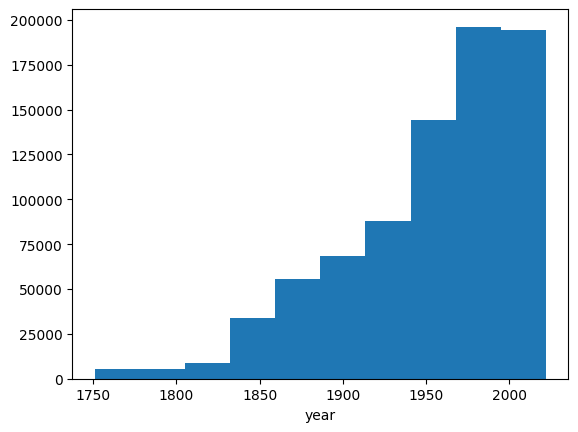

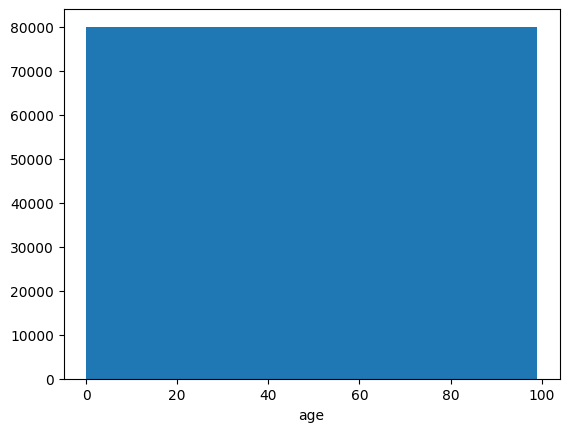

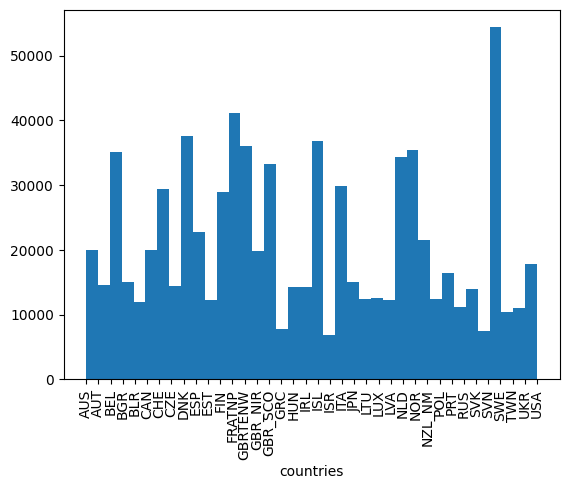

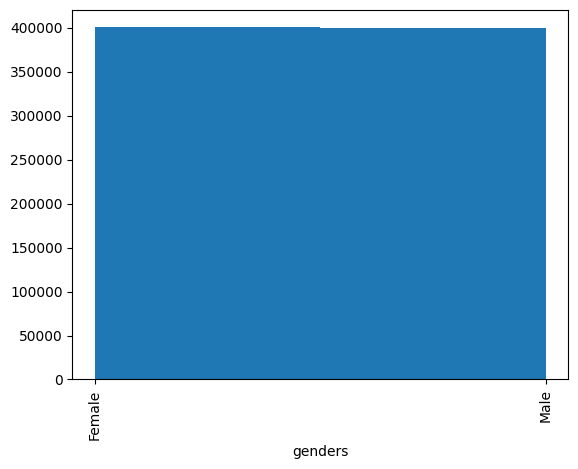

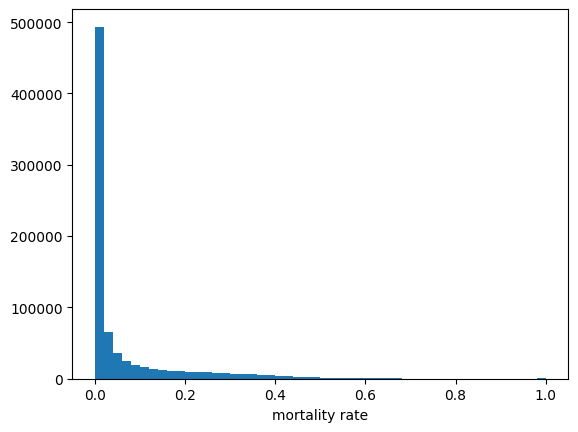

In [3]:
# eda
plt.figure()
plt.hist(data[:, 0])
plt.xlabel("year")
plt.show()

plt.figure()
plt.hist(data[:, 1])
plt.xlabel("age")
plt.show()

plt.figure()
plt.hist(data[:, 2], bins=len(countries))
plt.xlabel("countries")
country_position = np.arange(len(countries))
plt.xticks(country_position, countries, rotation=90)
plt.show()

plt.figure()
plt.hist(data[:, 3], bins=len(genders))
plt.xlabel("genders")
gender_position = np.arange(len(genders))
plt.xticks(gender_position, genders, rotation=90)
plt.show()

plt.figure()
plt.hist(data[:, 4], bins=50)
plt.xlabel("mortality rate")
plt.show()

In [4]:
# set up training and test data using boolean vectors created with logical AND statement
training_index = np.logical_and(data[:, 0] >= 1950, data[:, 0] <= 1990)
training_data = data[training_index, :]
test_index = np.logical_and(data[:, 0] > 1990, data[:, 0] <= 2000)
test_data = data[test_index, :]

In [5]:
training_data = tf.convert_to_tensor(training_data)
test_data = tf.convert_to_tensor(test_data)
# cast tensor to type float32
training_data = tf.cast(training_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
num_train = training_data.shape[0]
num_test = test_data.shape[0]

In [6]:
# define function to fetch and process data entries from training or test data 
def get_data(index, mode):
    if mode == "train":
        # randomly selects index from training data between 0 and num_train
        rand_index = tf.random.uniform([],minval=0, maxval=num_train, dtype=tf.int32) 
        entry = training_data[rand_index, :]
    elif mode == "not_random":
        # selects specified index from test data 
        entry = test_data[index, :]
    else: 
        # for any other value of mode, randomly selects index from test
        rand_index = tf.random.uniform([],minval=0, maxval=num_test, dtype=tf.int32)
        entry = test_data[rand_index, :]
    year, age, country, gender, rate = entry[0], entry[1], entry[2], entry[3], entry[4]
    year = (year - 1950)/50
    age = tf.cast(age, tf.int32)
    country = tf.cast(country, tf.int32)
    gender = tf.cast(gender, tf.int32)
    year = tf.reshape(year, [1])
    age = tf.reshape(age, [1])
    country = tf.reshape(country, [1])
    gender = tf.reshape(gender, [1])
    rate = tf.reshape(rate, [1])
    return (year, age, country, gender), rate

In [7]:
def get_figure_data(year, country, gender):
    #index = np.logical_and(combined_data[:,0] == year, combined_data[:,1] == age, combined_data[:, 2] == country, combined_data[:, 3] == gender)
    
        indices = (data[:, 0] == year) & \
                (data[:, 2] == country) & \
                (data[:, 3] == gender)

        entries = data[indices, :]
        
        entries_data = []
        entries_rate = []
        for entry in entries:
                year, age, country, gender, rate = entry[0], entry[1], entry[2], entry[3], entry[4]
                year = (year - 1961)/50
                age = tf.cast(age, tf.int32)
                country = tf.cast(country, tf.int32)
                gender = tf.cast(gender, tf.int32)
                year = tf.reshape(year, [1])
                age = tf.reshape(age, [1])
                country = tf.reshape(country, [1])
                gender = tf.reshape(gender, [1])
                rate = tf.reshape(rate, [1])
                entries_data.append([year, age, country, gender])
                entries_rate.append(rate)

        return entries_data, entries_rate

In [8]:
# use get_data function to set up training and test tensorflow datasets 
dataset_train = tf.data.Dataset.from_tensor_slices(np.arange(10000))
dataset_train = dataset_train.repeat()
dataset_train = dataset_train.map(lambda x: get_data(x, mode="train"), num_parallel_calls=4)
dataset_train = dataset_train.batch(256)
dataset_train = dataset_train.prefetch(buffer_size=512)

dataset_test = tf.data.Dataset.from_tensor_slices(np.arange(10000))
dataset_test = dataset_test.repeat()
dataset_test = dataset_test.map(lambda x: get_data(x, mode="test"), num_parallel_calls=4)
dataset_test = dataset_test.batch(256)
dataset_test = dataset_test.prefetch(buffer_size=512)

In [9]:
for (year, age, country, gender), rate in dataset_test:
    break
    
batch_index = 0
print("year:", year.numpy()[batch_index, 0])
print("age:", age.numpy()[batch_index, 0])
print("country:", country.numpy()[batch_index, 0])
print("gender:", gender.numpy()[batch_index, 0])
print("rate:", rate.numpy()[batch_index, 0])

year: 1.0
age: 47
country: 28
gender: 0
rate: 0.001902


In [10]:
# defining inputs 
year = tfkl.Input(shape=(1,), dtype='float32', name='Year')
age =  tfkl.Input(shape=(1,), dtype='int32', name='Age')
country = tfkl.Input(shape=(1,), dtype='int32', name='Country')
gender = tfkl.Input(shape=(1,), dtype='int32', name='Gender')

# defining embedding layers 
age_embed = tfkl.Embedding(input_dim=100, output_dim=5, input_length=1, name='Age_embed')(age)
age_embed = tfkl.Flatten()(age_embed)

gender_embed = tfkl.Embedding(input_dim=2, output_dim=5, input_length=1, name='Gender_embed')(gender)
gender_embed = tfkl.Flatten()(gender_embed)

country_embed = tfkl.Embedding(input_dim=38, output_dim=5, input_length=1, name='Country_embed')(country)
country_embed = tfkl.Flatten()(country_embed)

# create feature vector that concatenates all inputs 
x = tfkl.Concatenate()([year, age_embed, gender_embed, country_embed])
x1 = x

# setting up middle layers 
x = tfkl.Dense(128, activation='tanh')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.05)(x)

x = tfkl.Dense(128, activation='tanh')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.05)(x)

x = tfkl.Dense(128, activation='tanh')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.05)(x)

x = tfkl.Dense(128, activation='tanh')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.05)(x)

# setting up output layer 
x = tfkl.Concatenate()([x1, x])
x = tfkl.Dense(128, activation='tanh')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.05)(x)
x = tfkl.Dense(1, activation='sigmoid', name='final')(x)

# creating the model 
model = tf.keras.Model(inputs=[year, age, country, gender], outputs=[x])

In [11]:
# compiling the model
model.compile(loss='mse', optimizer='adam')

In [12]:
model.fit(dataset_train, steps_per_epoch=1000, validation_data=dataset_test, validation_steps=500, epochs=9, verbose=2)

Epoch 1/9
1000/1000 - 8s - loss: 0.0144 - val_loss: 0.0019 - 8s/epoch - 8ms/step
Epoch 2/9
1000/1000 - 6s - loss: 0.0020 - val_loss: 6.4779e-04 - 6s/epoch - 6ms/step
Epoch 3/9
1000/1000 - 6s - loss: 0.0014 - val_loss: 5.8811e-04 - 6s/epoch - 6ms/step
Epoch 4/9
1000/1000 - 6s - loss: 0.0012 - val_loss: 4.6327e-04 - 6s/epoch - 6ms/step
Epoch 5/9
1000/1000 - 6s - loss: 0.0011 - val_loss: 7.4323e-04 - 6s/epoch - 6ms/step
Epoch 6/9
1000/1000 - 6s - loss: 0.0010 - val_loss: 4.9548e-04 - 6s/epoch - 6ms/step
Epoch 7/9
1000/1000 - 6s - loss: 9.8710e-04 - val_loss: 6.8549e-04 - 6s/epoch - 6ms/step
Epoch 8/9
1000/1000 - 6s - loss: 9.6319e-04 - val_loss: 5.0940e-04 - 6s/epoch - 6ms/step
Epoch 9/9
1000/1000 - 7s - loss: 9.2287e-04 - val_loss: 4.6370e-04 - 7s/epoch - 7ms/step


In [13]:
dataset_test2 = tf.data.Dataset.from_tensor_slices(np.arange(10000))
dataset_test2 = dataset_test2.repeat()
dataset_test2 = dataset_test2.map(lambda x: get_data(x, mode="not_random"), num_parallel_calls=4)
dataset_test2 = dataset_test2.batch(100)
dataset_test2 = dataset_test2.prefetch(buffer_size=512)

In [31]:
fig_data, fig_rate = get_figure_data(2017, 37, 0)
fig_rate = np.array(fig_rate)
fig_predictions = []
for age_row in fig_data:
    inputs = age_row[0], age_row[1], age_row[2], age_row[3]
    predictions = model(inputs)
    fig_predictions.append(predictions)
fig_predictions = np.array(fig_predictions)

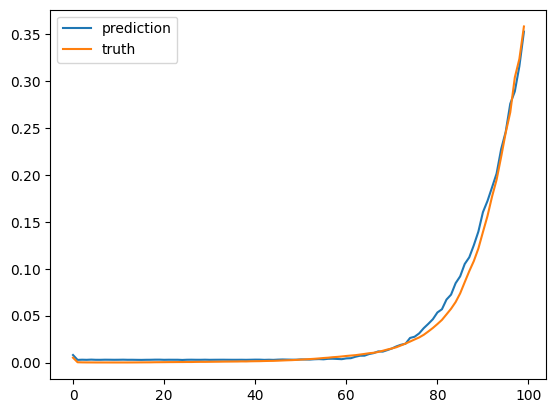

In [32]:
plt.figure()
plt.plot(fig_predictions[:, 0], label="prediction")
plt.plot(fig_rate[:, 0], label="truth")
plt.legend()
plt.show()

In [16]:
# iterate through first 3000 batches of dataset_test2
j=0
for inputs, output in dataset_test2:
    j += 1
    if j > 3000:
        break
    # use trained model to make predictions on the last batch processed
    predictions = model(inputs)

NameError: name 'output' is not defined

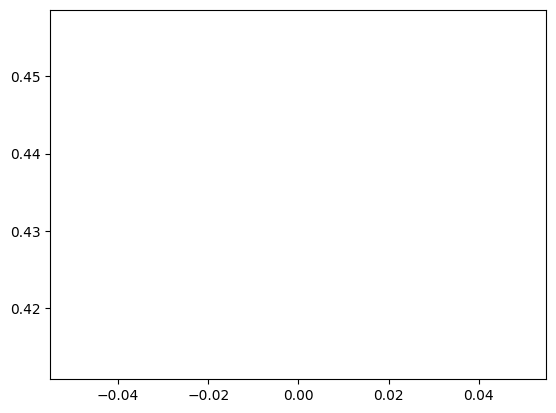

In [65]:
plt.figure()
plt.plot(predictions[:, 0], label="prediction")
plt.plot(output[:, 0], label="truth")
plt.legend()
plt.show()

In [15]:
output.shape
predictions.shape

TensorShape([100, 1])